In [1]:
#TARGIL No. 1 
# By Sahar Goelman
# selected database: rasturants.csv
#TODO: add link to the resource

In [23]:
%pylab inline
import os
import datetime


Populating the interactive namespace from numpy and matplotlib


C:\Users\sgoel\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'std', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
## Validate that the database file exists otherwise break
if  not os.path.isfile("resturants.csv"):
    print("please add resturants.csv to :"+os.getcwd())

In [25]:
#question (1) loading the database
csv = sc.textFile("resturants.csv")

csv_header = csv.first() 
print("Column names:",format(csv_header))
csv_data = csv.filter(lambda line : line != csv_header) #remove csv headers from data
print("Number of rows loaded: {}".format(csv.count()))

Column names: business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category


Number of rows loaded: 53577


In [26]:
class FiveHeaders:
    def __init__(self):
        self.values = []
        self.csv_header = dict()
    def add_headers(self, key, val):
        self.csv_header[key] = val
    def get_header(self, key):
        return self.csv_header[key]
    def get_all_values(self):
        self.values = list(self.csv_header.values())
        return self.values
    def get_index_from_key(self, key):
        index_in_header = self.get_header(key)
        self.values.index(index_in_header)
        return self.values.index(index_in_header)


split_headers= csv_header.split(",")
fiveHeaders = FiveHeaders()
headers = ['inspection_score'] #, 'business_id','business_id','business_id','business_id']
# headers = ['inspection_score', 'business_id','inspection_id','business_postal_code', 'business_phone_number']
for header in headers: 
     fiveHeaders.add_headers(header, split_headers.index(header))

# fiveHeaders.get_header('inspection_score')
fiveHeaders.get_all_values()



[12]

In [27]:
#problem number (2):

#RDD is assumed to contain an (unique) index column at position 0
def get_RDD_row_by_index(rdd, index=0):
    nrows = rdd.count()
    if index < nrows:
        return rdd.filter(lambda kv: kv[0] == index)
    return None

#RDD is assumed to contain the requested col_nama
def get_RDD_col_values(rdd, col_name):
    col_index = fv.get_index_from_key(col_name)
    return rdd.map(lambda line: line[1][col_index])


#add a unique_id and split csv using commas
baseData = csv_data.zipWithIndex().map(lambda line: (line[-1],line[:-1][0].split(",")))
print("Added unique id at column 0:\nfirst=: {}".format(baseData.first()))
print("Added unique id at column 0:\nfirst[1]: {}".format(baseData.first()[1]))
print("Added unique id at column 0:\nfirst[1][1]: {}".format(baseData.first()[1][1]))
#test our method to get the n'th row from RDD
#print("take the {}th row from Data: {}".format(75, get_RDD_row_by_index(baseData,75).first()))
print('number of rows in dataBase: {}'.format(baseData.count()))


Added unique id at column 0:
first=: (0, ['39810', 'Cherry Blossom Bakery', '844 Clement St', 'San Francisco', 'CA', '94118', '37.782778', '-122.468341', '"{\'latitude\': \'37.782778\'', " 'needs_recoding': False", ' \'human_address\': \'{""address"":""""', '""city"":""""', '""state"":""""', '""zip"":""""}\'', ' \'longitude\': \'-122.468341\'}"', '', '39810_20160308', '2016-03-08T00:00:00', '77', 'Routine - Unscheduled', '39810_20160308_103124', 'Inadequately cleaned or sanitized food contact surfaces', 'Moderate Risk'])


Added unique id at column 0:
first[1]: ['39810', 'Cherry Blossom Bakery', '844 Clement St', 'San Francisco', 'CA', '94118', '37.782778', '-122.468341', '"{\'latitude\': \'37.782778\'', " 'needs_recoding': False", ' \'human_address\': \'{""address"":""""', '""city"":""""', '""state"":""""', '""zip"":""""}\'', ' \'longitude\': \'-122.468341\'}"', '', '39810_20160308', '2016-03-08T00:00:00', '77', 'Routine - Unscheduled', '39810_20160308_103124', 'Inadequately cleaned or sanitized food contact surfaces', 'Moderate Risk']


Added unique id at column 0:
first[1][1]: Cherry Blossom Bakery


number of rows in dataBase: 53576


In [28]:
#problem number (3.a): unique values of the 5 columns 
#RDD is assumed to contain the requested col_name
#row 0 is the first row
def get_RDD_col_value(rdd, row_index, col_name):
    print ("header indexes are:{}".format(fiveHeaders.get_all_values()))
    col_index = fiveHeaders.get_index_from_key(col_name)
    row = get_RDD_row_by_index(rdd, row_index)
    val  = row.first()[1][col_index]
    print ("rdd[{}][{}] = {}".format(row_index, col_index,val))


get_RDD_col_value(baseData, 100, 'inspection_score')

header indexes are:[12]

rdd[100][0] = 63940


In [29]:
import math
#allows counting only numerical columns
class Data_Filter():
    def __init__(self, header_name):
        self.col_indexes = header_name.get_all_values()
        self.build_line = self._builder(self.list_creator)
        self.build_filter = self._builder(self.create_filter_is_num)
        
    def _builder(self, func):
        return func(self.col_indexes)

    def number(self, s):
        ret = None
        try:
            ret = int(s)
        except ValueError:
            ret = float(s)
        finally:
            return ret

    def is_not_number(self, s):
        ret = False
        try:
            #print("value = ".format(s))
            if (math.isnan(self.number(s))):  #not a number
                ret = True
        except:
            print("exception in is_not_number, s = {}".format(s))
            ret = True
        finally:
            return ret

    def list_creator(self, col_indexes):
        def get_unique_line(_line, unique_id, append_num=True):
            items = []
            for col in col_indexes:
                if append_num:
                    item = self.number(_line[col])
                else:
                    item = _line[col]
                items.append(item)
            return (unique_id, items)
        return get_unique_line


    def create_filter_is_num(self, col_indexes):

        def check_is_number(_line):
            ret = True
            for col in col_indexes:
                try:
                    #print ("_line = {}".format(_line))
                    #print ("value[{}]: {}".format(col, _line[col]))
                    if (math.isnan(self.number(_line[col]))):
                        ret = False
                except:
                    #TODO
                    print('create_filter_is_num caught an exception\n _line[{}]={}'.format(col, _line[col]))
                    ret = False
            return ret
        return check_is_number

print ("filtering data")
filtered_data = Data_Filter(fiveHeaders)
print(filtered_data)
print("end filtering data")

filtering data
end filtering data


In [30]:
i = 0
for col_name in headers: 
    print("index of col_names[{}] = {}".format(col_name,filtered_data.col_indexes[i]))
    i = i + 1
    
filteredByColumn = baseData.filter(lambda line: filtered_data.build_filter(line[1])).map(lambda line: filtered_data.build_line(line[1], line[0]))

def count_distinct(filter_by_column, headerName, key):
    res =  filter_by_column.map(lambda pair: pair[1][headerName.get_index_from_key(key)]).distinct().count()
    return res
def print_distinct(col_name):
        cnt = count_distinct(filteredByColumn, fiveHeaders, col_name)
        print('Distint values of col: {} = {}'.format(col_name, cnt))
        return cnt

index of col_names[inspection_score] = 12


In [31]:
#Question 3/a
col_distinct_counts = {}
for header in headers:
    res = print_distinct(header)
    col_distinct_counts[header] = res


Distint values of col: inspection_score = 85


Histogram of column:inspection_score


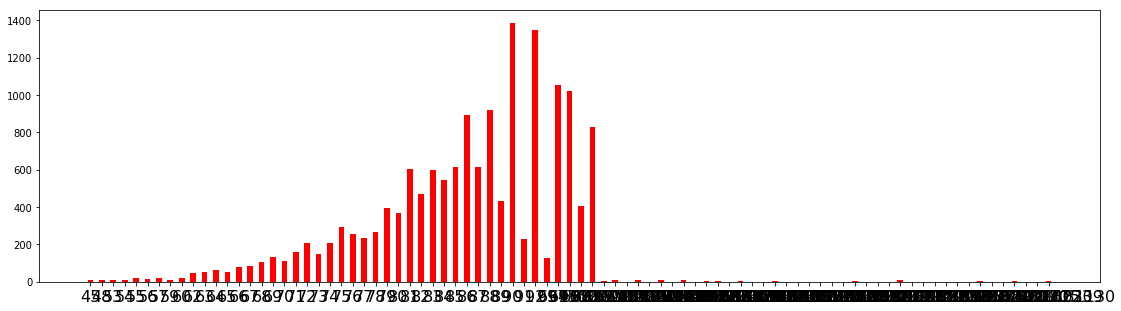

In [32]:
#Utility functions to plot histogram
class Histogram():

    def show(self, col_name, color):
        obj = self.countAggregateByKey(col_name)
        self.plot(obj,color)
    
    def countAggregateByKey(self, col_name):
        aggragateByKey = col_name.countByValue() 
        keys  = aggragateByKey.keys()
        x_axis = np.array(sorted(keys))
        y_axis = np.array([aggragateByKey.get(key) for key in x_axis])
        return self.buildObj(x_axis,y_axis)
    
    def buildObj(self, x_axis,y_axis):
        res = dict()
        res['x'] = {
            'pos': np.arange(len(x_axis)),
            'x_axis':x_axis
        }
        res['y']={
            'y_axis':y_axis
        }
        return res
    
    def plot(self, obj,color):
        y_axis = obj['y']['y_axis']
        pos = obj['x']['pos']
        x_axis = obj['x']['x_axis']

        ax = plt.axes()
        ax.set_xticks(pos)
        ax.set_xticklabels(x_axis)

        plt.bar(pos, y_axis, 0.5, color=color)
        plt.xticks(size=16)

        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(19, 5)
        plt.show()

#Question 3/b drawing histograms of the 5 columns
# get all indexes for a specific col name
# we normalize the "inpection_score" variable so that 
def filterColumnByHeader(filteredByColumn,col_names,key):
    return filteredByColumn.map(lambda pair: pair[1][col_names.get_index_from_key(key)])

histogram_colors = ['red', 'green', 'blue', 'yellow', 'magenta']
i = 0
h = Histogram()
for header in headers:
    data = filterColumnByHeader(filteredByColumn,fiveHeaders,header)#
    print ("Histogram of column:{}".format(header))
    h.show(data, histogram_colors[i])
    i = i + 1


In [ ]:
##############################################################################################
#Will Do now all data Manipulations on inspection_score column 
##############################################################################################

In [12]:

# BAD Vauues
for i in range(0, len(headers)):
    NA_col = csv_data.filter(lambda x: x[0][i] == None)
    print("Non or empty values in col , ", "inspection_score are :", NA_col.count())
### No None values 

Non or empty values in col ,  inspection_score are : 0


In [19]:
is_col=fiveHeaders.get_index_from_key("inspection_score")
rdd_inspection_score = filteredByColumn.map(lambda pair: pair[1][is_col])


In [20]:
mean = rdd_inspection_score.mean()
std = rdd_inspection_score.stdev()
print("Mean is:", mean)
print("Standard deviation is:", std)


Mean is: 48592669003.806595
Standard deviation is: 628299761361.48


In [15]:
# normalized :
norm=filteredByColumn.map(lambda x:(x[1][is_col]-mean)/std)
n_mean = norm.mean()
n_std = norm.stdev()
print("normalized Mean is:", n_mean)
print("normalized Standard deviation is:", n_std)

normalized Mean is: 1.185910330579189e-16
normalized Standard deviation is: 1.0000000000000002
